For quicker iteration I define BSVClassifier also in this jupyter

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np

plt.rcParams['figure.figsize'] = (15.0, 5.0)

In [3]:
import sys

sys.path.append('..')

In [4]:
from flod.features_extraction import load_features
from flod.dataset import download_dataset
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from flod.classifiers.bsvclassifier import BSVClassifier
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, make_scorer

In [5]:
CACHE_FOLDER = '../cache'
load_features.LABELS_PATH = '../labels.json'

In [6]:
dataset_path = download_dataset(CACHE_FOLDER)
dataset = load_features.load_features(CACHE_FOLDER, dataset_path)

39it [00:26,  1.48it/s]


In [7]:
dataset

,x,y,z,fx,fy,fz,svm,f_svm,svmh,f_svmh,is_fall,c2,c1,c3,c4
0,0.105469,-0.984375,-0.144531,0.105546,-0.987508,-0.146812,1.000503,1.003925,0.178922,0.180814,0,0.000000,0.000000,0.000000,0.000000
1,0.121094,-0.992188,-0.128906,0.107950,-0.987142,-0.148372,1.007828,1.004050,0.176863,0.183487,0,0.000000,0.000000,0.000000,0.000000
2,0.109375,-0.988281,-0.125000,0.110380,-0.986695,-0.149925,1.002142,1.004105,0.166096,0.186175,0,0.000000,0.000000,0.000000,0.000000
3,0.113281,-0.992188,-0.156250,0.112821,-0.986146,-0.151458,1.010783,1.004068,0.192994,0.188860,0,0.000000,0.000000,0.000000,0.000000
4,0.113281,-0.984375,-0.125000,0.115258,-0.985478,-0.152959,0.998725,1.003917,0.168694,0.191523,0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.515625,-0.121094,0.722656,0.518003,-0.122563,0.722714,0.895971,0.897588,0.887751,0.889181,0,0.890521,0.899253,0.064198,1.435784
2996,0.515625,-0.140625,0.730469,0.517800,-0.122397,0.722704,0.905113,0.897440,0.894122,0.889054,0,0.890411,0.899133,0.064198,1.435228
2997,0.515625,-0.121094,0.722656,0.517615,-0.122248,0.722694,0.895971,0.897305,0.887751,0.888939,0,0.890429,0.899180,0.064198,1.414797
2998,0.515625,-0.117188,0.714844,0.517449,-0.122116,0.722685,0.889159,0.897184,0.881403,0.888835,0,0.890486,0.899208,0.064198,1.435228


In [8]:
X_full = dataset[['c1','c2', 'c3', 'c4']]
y = dataset['is_fall']

In [9]:
X = PCA(n_components=2).fit_transform(X_full)

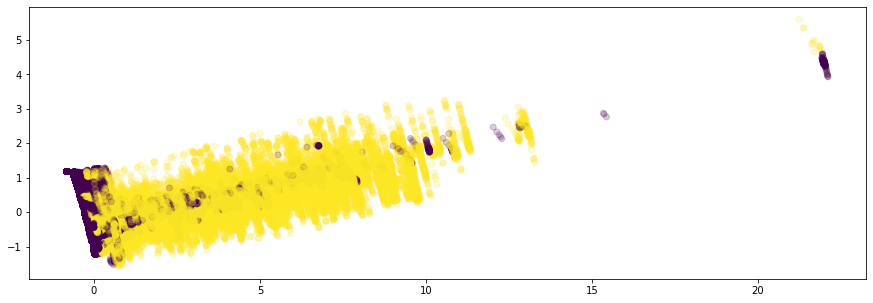

In [10]:
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=.2)
plt.show()

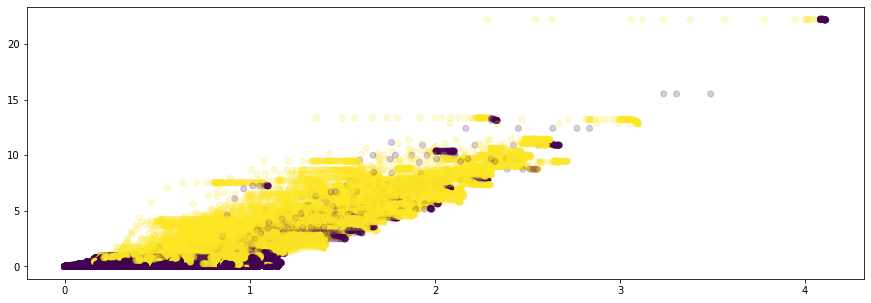

In [11]:
plt.scatter(dataset['c2'], dataset['c3'], c=y,  alpha=.2)
plt.show()

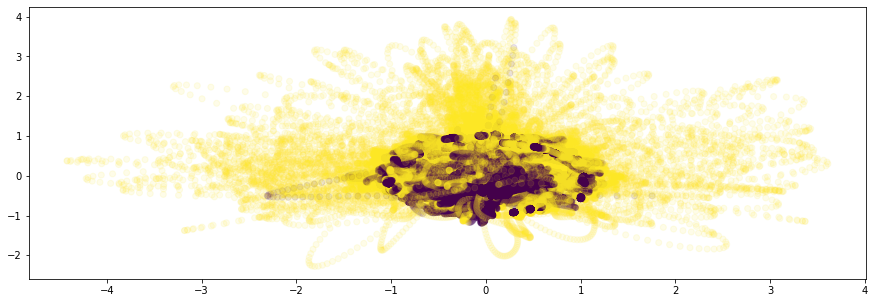

In [12]:
plt.scatter(dataset['fx'], dataset['fz'], c=y, alpha=.1)
plt.show()

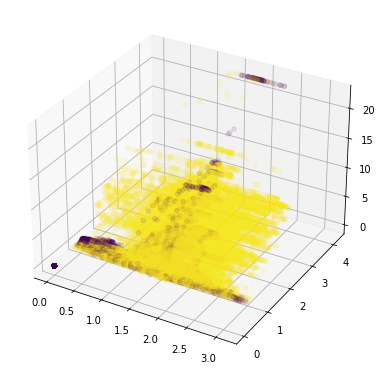

In [16]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(dataset['c4'], dataset['c1'], dataset['c3'], c=y, alpha=.1)
plt.show()